## Pre Processing

In [4]:
import numpy as np
import pandas as pd
files = ['/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay2CorrelationData/Day2MasterCorrelationRawData.csv','/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay4/Day4MasterCorrelationRawData.csv','/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay2CorrelatedWithRNADay4/Day2vsDay4RNAMasterCorrelationRawData.csv','/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay10Corr/ChipDay10Corr293T.csv']
names = {
              '/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay2CorrelationData/Day2MasterCorrelationRawData.csv':"Day 2",
              '/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay4/Day4MasterCorrelationRawData.csv': "Day 4",
              '/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay2CorrelatedWithRNADay4/Day2vsDay4RNAMasterCorrelationRawData.csv': "Day 2 vs. Day 4",  
              '/Users/yeshdoctor/Desktop/Duke/LAB/ChipDay10Corr/ChipDay10Corr293T.csv': "Day 10"
        }

def swap(arr):
        t = [[],[],[],[]]
        temp0 = arr[0]
        temp1 = arr[1]
        temp2 = arr[2]
        temp3 = arr[3]
        t[0] = temp2
        t[1] = temp3
        t[2] = temp0
        t[3] = temp1
        return t

def process(file,nan_pad = 0.0):  
    df = pd.read_csv(file)
    df = df.iloc[:, 0:11]
    df.fillna(value=nan_pad,inplace=True)
    DKK1_RNA = ((df.loc[df["Gene"]=="DKK1_RNA"]))
    DKK1_RNA = DKK1_RNA.to_numpy()[0,2:]
    IGF_RNA = ((df.loc[df["Gene"]=="IGFBPL1_RNA"]))
    IGF_RNA = IGF_RNA.to_numpy()[0,2:]
    MLNR_RNA = ((df.loc[df["Gene"]=="MLNR_RNA"]))
    MLNR_RNA = MLNR_RNA.to_numpy()[0,2:]
    DKK1_CHIP = ((df.loc[df["Gene"]=="DKK1_CHIP"]))
    DKK1_CHIP = DKK1_CHIP.to_numpy()[:,2:]
    IGF_CHIP = ((df.loc[df["Gene"]=="IGFBPL1_CHIP"]))
    IGF_CHIP = IGF_CHIP.to_numpy()[:,2:]
    MLNR_CHIP = ((df.loc[df["Gene"]=="MLNR_CHIP"]))
    MLNR_CHIP = MLNR_CHIP.to_numpy()[:,2:]
    DKK1_CHIP = swap(DKK1_CHIP)
    IGF_CHIP = swap(IGF_CHIP)
    MLNR_CHIP = swap(MLNR_CHIP)
    DKK1_DATA = np.vstack((DKK1_RNA, DKK1_CHIP)).T
    MLNR_DATA = np.vstack((MLNR_RNA, MLNR_CHIP)).T
    IGF_DATA = np.vstack((IGF_RNA, IGF_CHIP)).T
    return DKK1_DATA, MLNR_DATA, IGF_DATA

def xy_split(arr,ignore_me):
    x = [x[1:].tolist()  for x in arr]
    y = [y[0] for y in arr]
    if(ignore_me):
        y=y[:7]
        x = [z[1:] for z in x[:7]]
    return x,y

## Simple Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy.ma as ma
sns.set(style = "white")
h_marks = ["H3K9me3", "H3K9ac", "H4K16ac", "H3K27ac"]
h_marks2 = ["H3K9ac", "H4K16ac", "H3K27ac"]
c = [sns.xkcd_rgb["light red"],sns.xkcd_rgb["sea green"],sns.xkcd_rgb["neon blue"],sns.xkcd_rgb["light lilac"]]
c2 = [sns.xkcd_rgb["light red"],sns.xkcd_rgb["sea green"],sns.xkcd_rgb["neon blue"]]
def lin_regress(x,y, test_name):
    fit = LinearRegression().fit(np.array(x),np.array(y))
    score = round(fit.score(x, y),3)
    weights = [round(x,3) for x in fit.coef_]
    offset = round(fit.intercept_,3)
    #fmt_weights = "{}(H3K9me3), {}(H3K9ac), {}(H4K16ac), {}(H3K27ac)".format(weights[0],weights[1],weights[2],weights[3])
    #print("Test: {}\nScore: {}\nWeights: {}\nOffset: {}\n".format(test_name,str(score),fmt_weights,str(offset)))
    return score,weights,offset

def plot_weights(weights, test_name, score,histone_marks,col):
    plt.bar(histone_marks,weights,color=col)
    plt.axhline(0, color='black', lw=2)
    plt.xticks(rotation=30,fontsize=14)
    plt.ylabel("Weights",fontsize=14)
    plt.title("{} (Score: {}) ".format(test_name,str(score)),fontsize = 16)
    
def lt(x):
    x=ma.log(x)
    x.filled(0.0)
    return x

    
def lrm(files,log_transform=False,ignore_me = False):
    plt.figure(figsize = (15,22))
    plt.subplots_adjust(hspace = 0.5, wspace = 0.4)
    subplot_number = 0
    for i,file in enumerate(files):
        DKK1,MLNR,IGFBPL1 = process(file,nan_pad=0.0)
        genes = [DKK1,MLNR,IGFBPL1]
        t_name = names[file]
        t_names = [t_name+" "+"DKK1", t_name+" "+"MLNR", t_name+" "+"IGFBPL1",]
        for j,gene in enumerate(genes):
            x,y=xy_split(gene,ignore_me)
            if(log_transform): x = lt(x)
            s,w,o = lin_regress(x,y,t_names[j])
            subplot_number = subplot_number+1
            plt.subplot(len(files),3,subplot_number)
            if(ignore_me): plot_weights(w,t_names[j],s,h_marks2,c2)
            else: plot_weights(w,t_names[j],s,hmarks,c)
    plt.savefig("LinearRegressionModel.png",dpi=300)

## Leave One Out Cross Validation

In [6]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error as score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy
import numpy.ma as ma

models = [LinearRegression(),BayesianRidge(),SVR(),DecisionTreeRegressor()]
model_names = ["Linear Regression", "Bayesian Ridge","Support Vector Machine","Decision Tree"]
ablated_sample = ["H3K9me3", "H3K9ac", "H4K16ac", "H3K27ac"]
ablated_sample2 = ["H3K9ac", "H4K16ac", "H3K27ac"]
c = [sns.xkcd_rgb["light red"],sns.xkcd_rgb["sea green"],sns.xkcd_rgb["neon blue"],sns.xkcd_rgb["light lilac"]]
c2 = [sns.xkcd_rgb["light red"],sns.xkcd_rgb["sea green"],sns.xkcd_rgb["neon blue"]]
def cross_validate(x,y,h):
    loo = LeaveOneOut()
    ytrue = []
    yhat = []
    for train_index, test_index in loo.split(x):
        x_train, x_test = [x[i] for i in train_index], x[test_index[0]]
        y_train, y_test = [y[i] for i in train_index], y[test_index[0]]
        model = h.fit(x_train,y_train)
        ytrue.append(y_test)
        yhat.append(model.predict([x_test]))
    return round(score(ytrue,yhat),6)


def ablate_mark(i,x):
    x2 = deepcopy(x)
    for x_k in x2:
        x_k[i] = 0.0
    return x2


def ablation(gene, model,log_transform,ignore_me):
    no_samples = 4
    if(ignore_me): no_samples = 3
    x,y = xy_split(gene,ignore_me)
    if(log_transform):
        x = lt(x)
    s = []
    for i in range(0,no_samples):
        x2 = ablate_mark(i,x)
        score = cross_validate(x2,y,model)
        s.append(score)
    s = np.array(s)
    s = s/(cross_validate(x,y,model))
    s = s - 1.0
    return s

def plot_cv(s,test_name,ab_samples,col):
    plt.bar(ab_samples,s,color=col)
    plt.axhline(0, color='black', lw=2)
    plt.xticks(rotation=30,fontsize=14)
    plt.ylabel("Normalized Cross Validation Score",fontsize=14)
    plt.xlabel("Ablated Sample",fontsize=14)
    plt.title("{}".format(test_name),fontsize = 16)

def analyse(files,log_transform=False,ignore_me=False):
    for m_name, model in enumerate(models):
        plt.figure(figsize = (15,22))
        plt.suptitle(model_names[m_name],fontsize=26,y=0.92)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.4)
        subplot_number = 0
        for i,file in enumerate(files):
            DKK1,MLNR,IGFBPL1 = process(file,nan_pad=0.0)
            genes = [DKK1,MLNR,IGFBPL1]
            t_name = names[file]
            t_names = [t_name+" "+"DKK1", t_name+" "+"MLNR", t_name+" "+"IGFBPL1"]
            for j,gene in enumerate(genes):
                    subplot_number = subplot_number + 1
                    s = ablation(gene,model,log_transform,ignore_me)
                    #print("Test: {}, Normalized Cross Validation Scores: {}".format(t_names[j],str(s)))
                    plt.subplot(len(files),3,subplot_number)
                    if(ignore_me): plot_cv(s,t_names[j],ablated_sample2,c2)
                    else: plot_cv(s,t_names[j],ablated_sample,c)

## Spearman Ablation

In [7]:
from scipy.stats import spearmanr as spearman
ablated_mark = ["None","H3K9ac", "H4K16ac", "H3K27ac"]
c = [sns.xkcd_rgb["light red"],sns.xkcd_rgb["sea green"],sns.xkcd_rgb["neon blue"],sns.xkcd_rgb["light lilac"]]

def ablate_mark_spearman(i,x):
    x2 = deepcopy(x)
    if(i==-1):
        return [np.mean(a) for a in x2]
    for x_k in x2:
        x_k[i] = 0.0
    return [np.mean(a) for a in x2]

def spearman_analysis(x,y):
    rho = []
    p_value = []
    for i in range(-1,3):   
        x2 = ablate_mark_spearman(i,x)
        r,p = spearman(x2,y)
        rho.append(round(r,3))
        p_value.append(round(p,3))
    return rho,p_value
    
def plot_spearman(r,p,test_name):
    plot = plt.bar(ablated_mark,r,color=c)
    label_p(plot,p)
    plt.axhline(0, color='black', lw=2)
    plt.xticks(rotation=30,fontsize=14)
    plt.ylabel("Spearman Correlation",fontsize=14)
    plt.xlabel("Ablated Sample",fontsize=14)
    plt.title(test_name,fontsize=16)
    
def label_p(plot,p):
    for i,bar in enumerate(plot):
        height = bar.get_height()
        if (height >= 0) : 
            plt.annotate(p[i],
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, -15),
                    textcoords="offset points",
                    ha='center', va='bottom')
        else: 
            plt.annotate(p[i],
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 15),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
def plot_weights(weights, test_name, score,histone_marks,col):
    plt.bar(histone_marks,weights,color=col)
    plt.axhline(0, color='black', lw=2)
    plt.xticks(rotation=30,fontsize=14)
    plt.ylabel("Weights",fontsize=14)
    plt.title("{} (Score: {}) ".format(test_name,str(score)),fontsize = 16)    
    
def spearman_ablation(files,log_transform=False):
    plt.figure(figsize = (15,22))
    plt.subplots_adjust(hspace = 0.5, wspace = 0.4)
    subplot_number = 0
    for i,file in enumerate(files):
        DKK1,MLNR,IGFBPL1 = process(file,nan_pad=0.0)
        genes = [DKK1,MLNR,IGFBPL1]
        t_name = names[file]
        t_names = [t_name+" "+"DKK1", t_name+" "+"MLNR", t_name+" "+"IGFBPL1",]
        for j,gene in enumerate(genes):
            x,y=xy_split(gene,ignore_me=True)
            if(log_transform): x = lt(x)
            r,p = spearman_analysis(x,y)
            subplot_number = subplot_number+1
            plt.subplot(len(files),3,subplot_number)
            plot_spearman(r,p,t_names[j])


In [114]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
cmap = sns.diverging_palette(220,10,sep=20,as_cmap=True)
import plotly.express as px

def split_xyz(x_vector):
    x = [a[0] for a in x_vector]
    y = [a[1] for a in x_vector]
    z = [a[2] for a in x_vector]
    return x,y,z

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def visualize_3D(files,log_transform=False):
    fig = plt.figure(figsize = (25,25))
    #plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
    subplot_number = 0
    midpoint = 1
    for i,file in enumerate(files):
        DKK1,MLNR,IGFBPL1 = process(file,nan_pad=0.0)
        genes = [DKK1,MLNR,IGFBPL1]
        t_name = names[file]
        t_names = [t_name+" "+"DKK1", t_name+" "+"MLNR", t_name+" "+"IGFBPL1",]
        for j,gene in enumerate(genes):
            x_vector,RNA=xy_split(gene,ignore_me=True)
            if(log_transform): 
                x_vector = lt(x_vector)
                RNA = lt(RNA)
                midpoint = 0
            x,y,z = split_xyz(x_vector)
            subplot_number = subplot_number+1
            ax = fig.add_subplot(len(files),3,subplot_number, projection='3d')
            plot = ax.scatter(x, y, z, cmap=cmap, marker='o',c = RNA, s = 80,norm=MidpointNormalize(midpoint=midpoint,vmin=min(RNA), vmax=max(RNA)))
            cbar = fig.colorbar(plot)
            cbar.set_label("RNA Expression",fontsize = 14)
            ax.set_xlabel('H3K9ac',fontsize = 14)
            ax.set_ylabel('H4K16ac',fontsize = 14)
            ax.set_zlabel('H3K27ac',fontsize = 14)
            ax.set_title(t_names[j],fontsize = 16)
    plt.savefig("visualization.png",dpi=300)

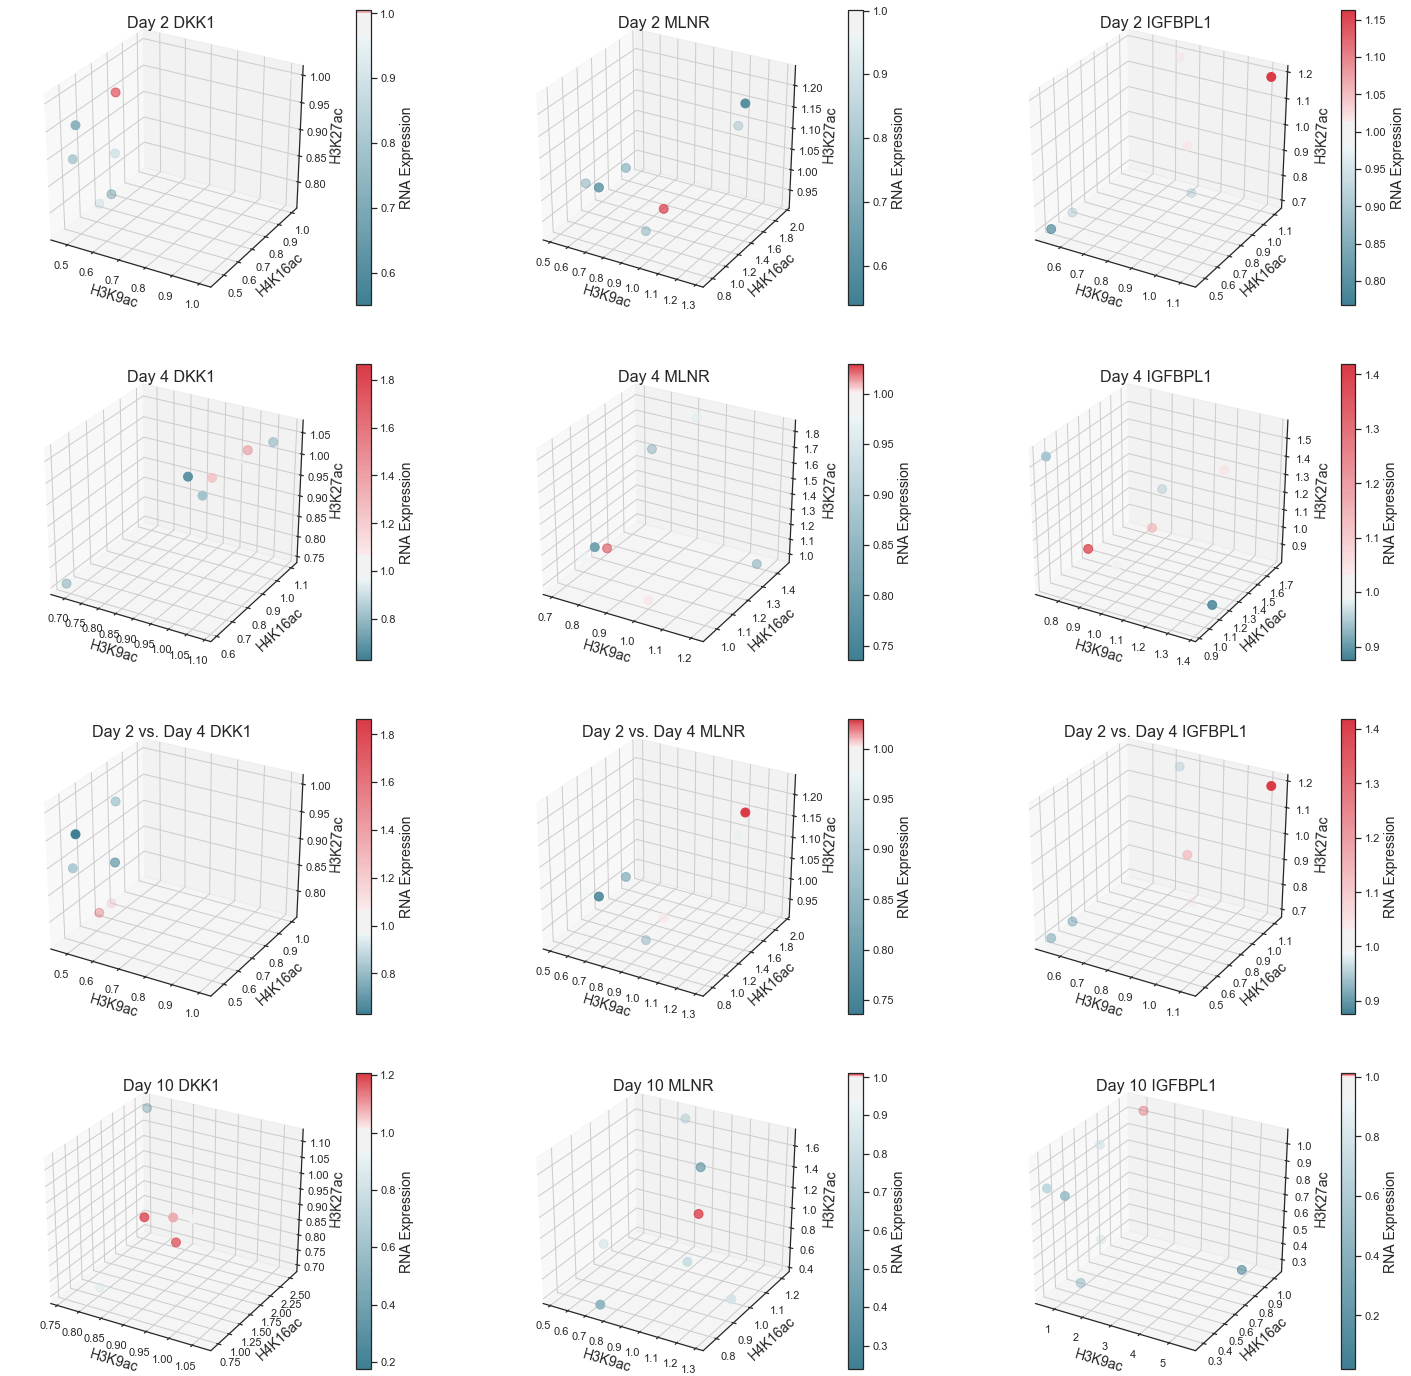

In [116]:
visualize_3D(files)

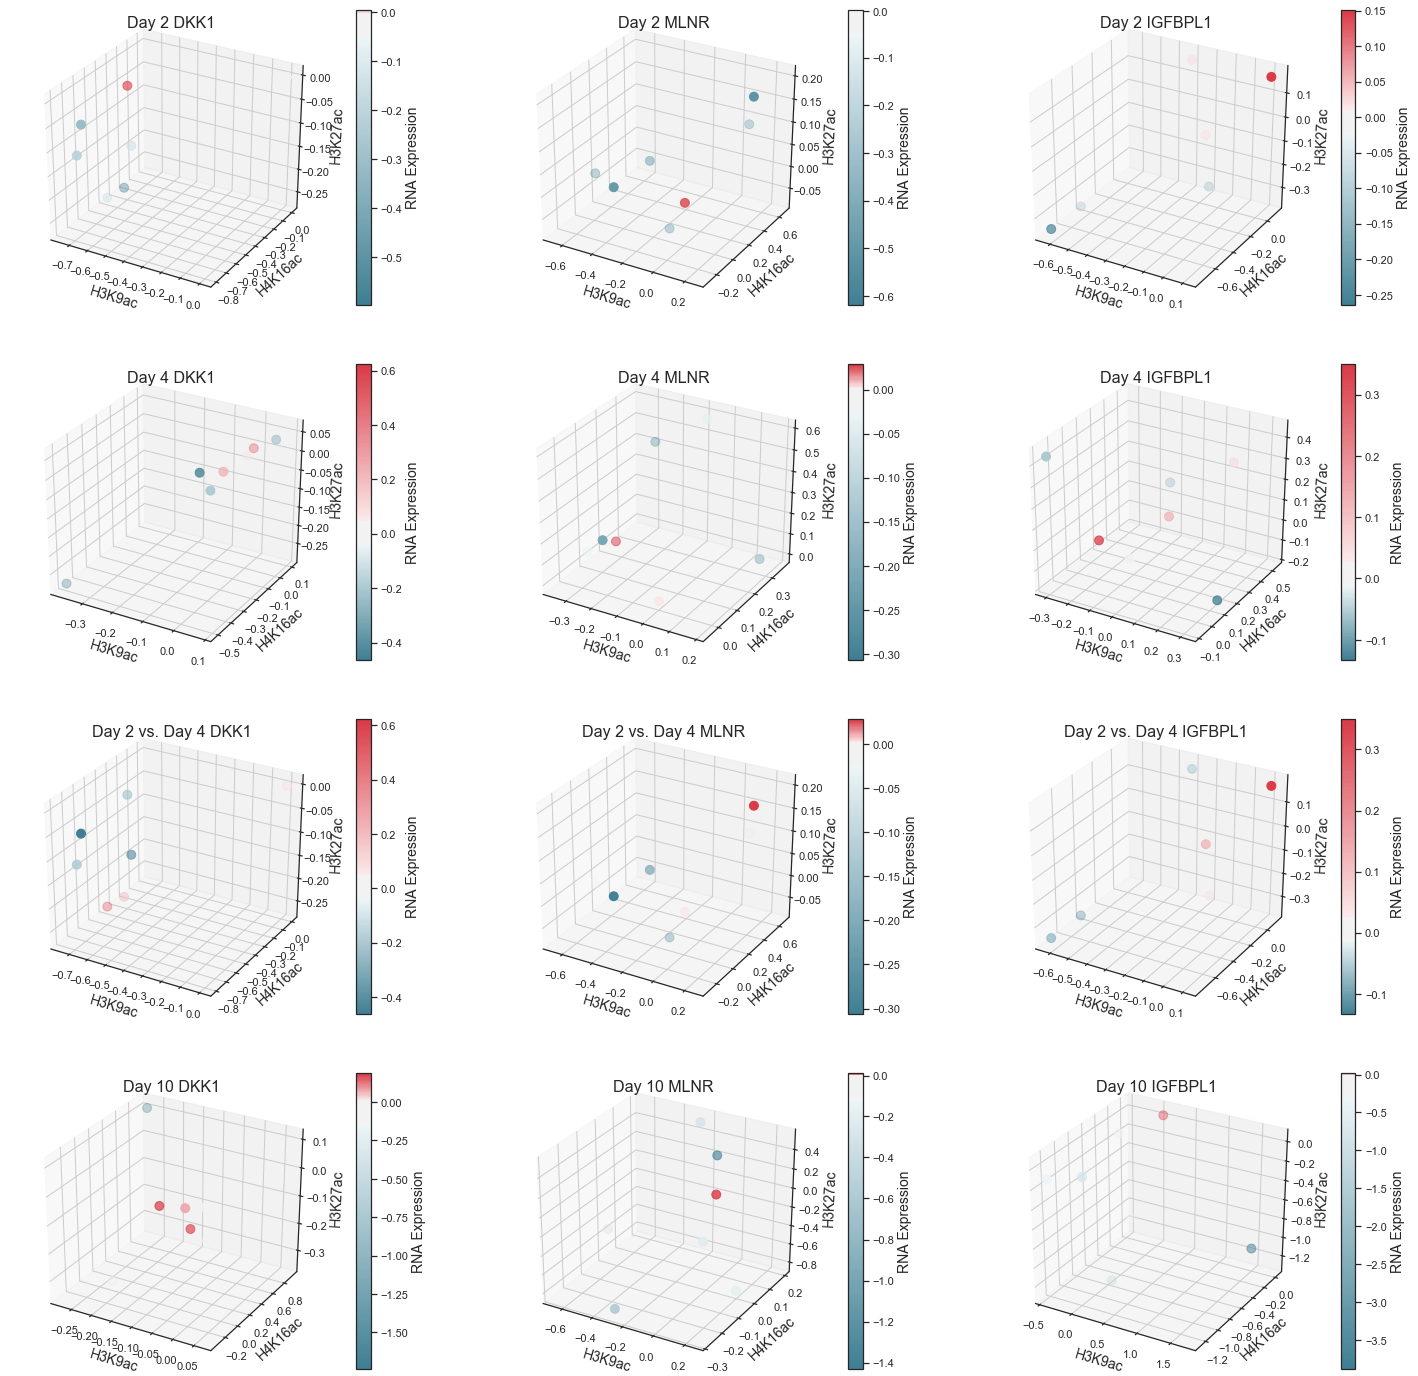

In [115]:
visualize_3D(files,log_transform=True)

In [ ]:
lrm(files,ignore_me=True)
#score printed represents r^2

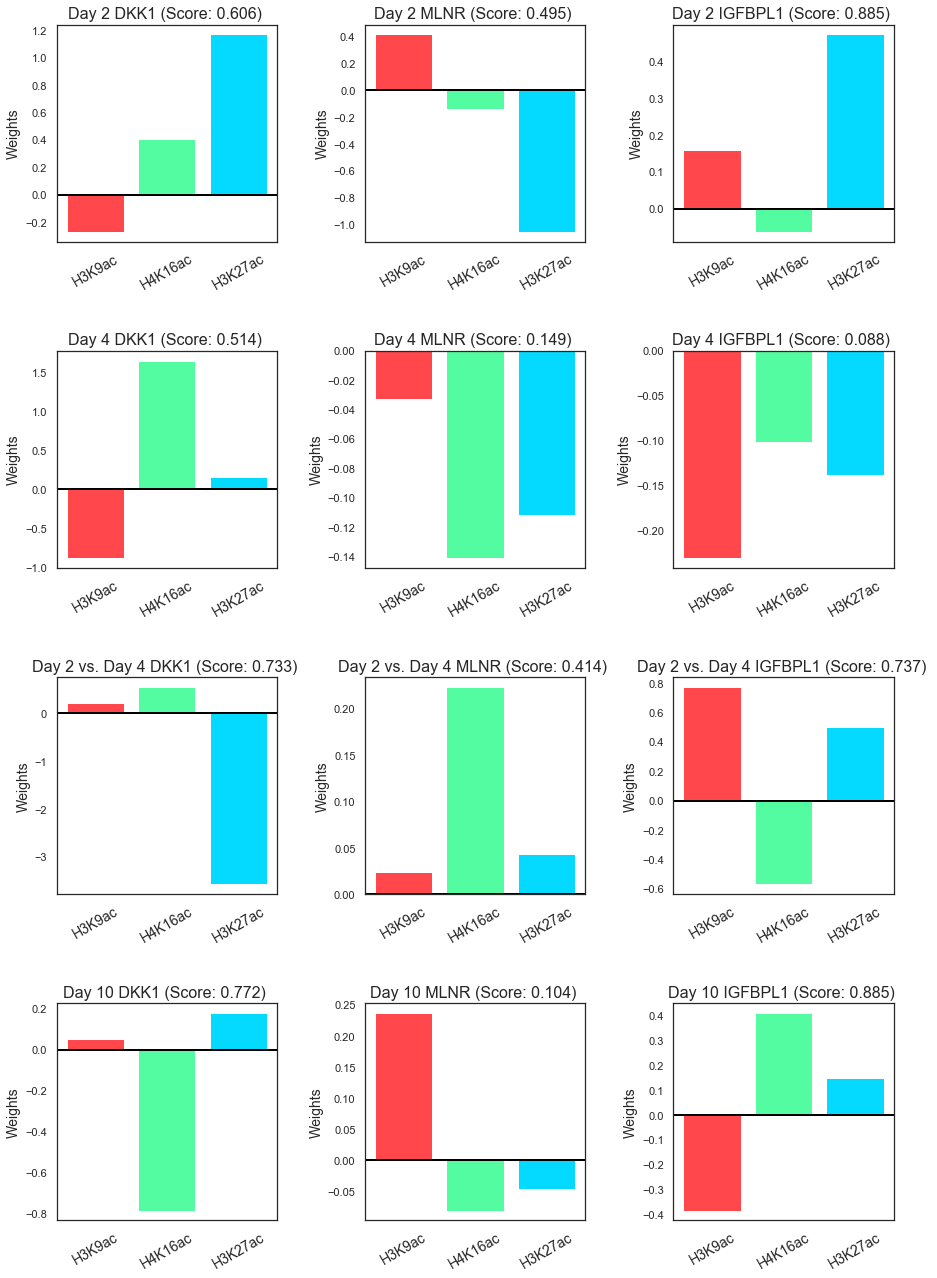

In [33]:
lrm(files,log_transform=True,ignore_me=True)

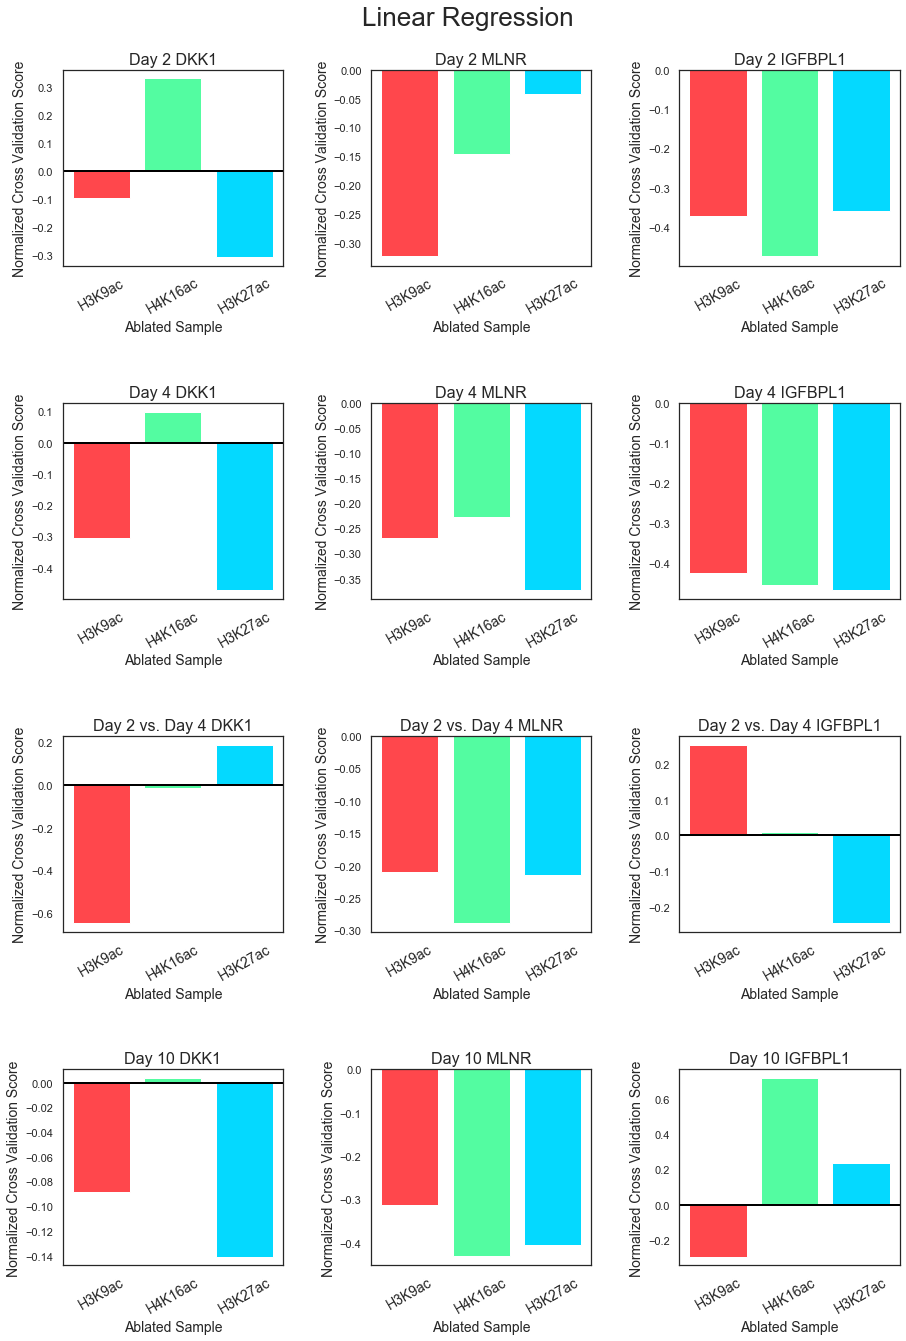

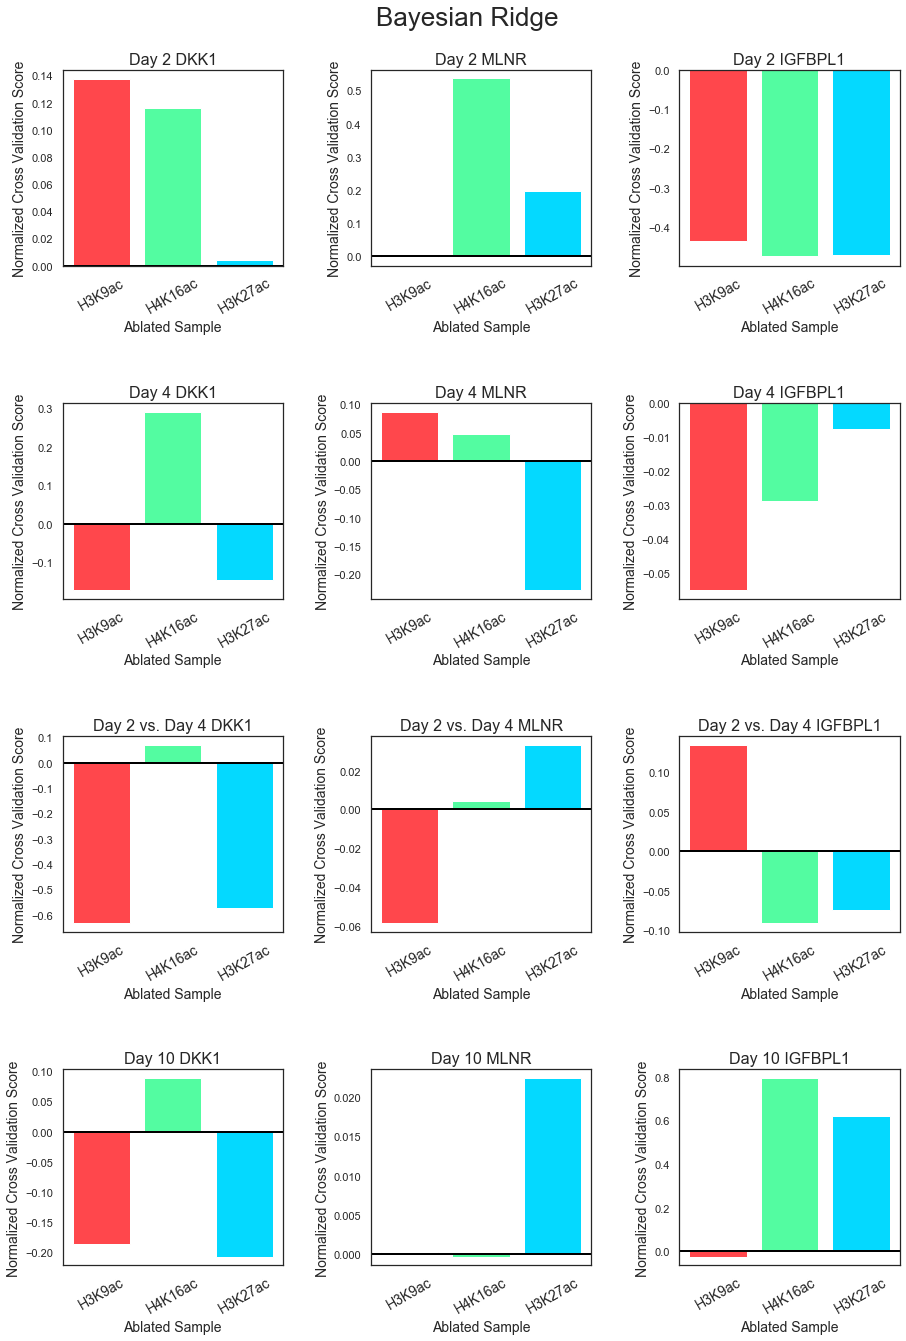

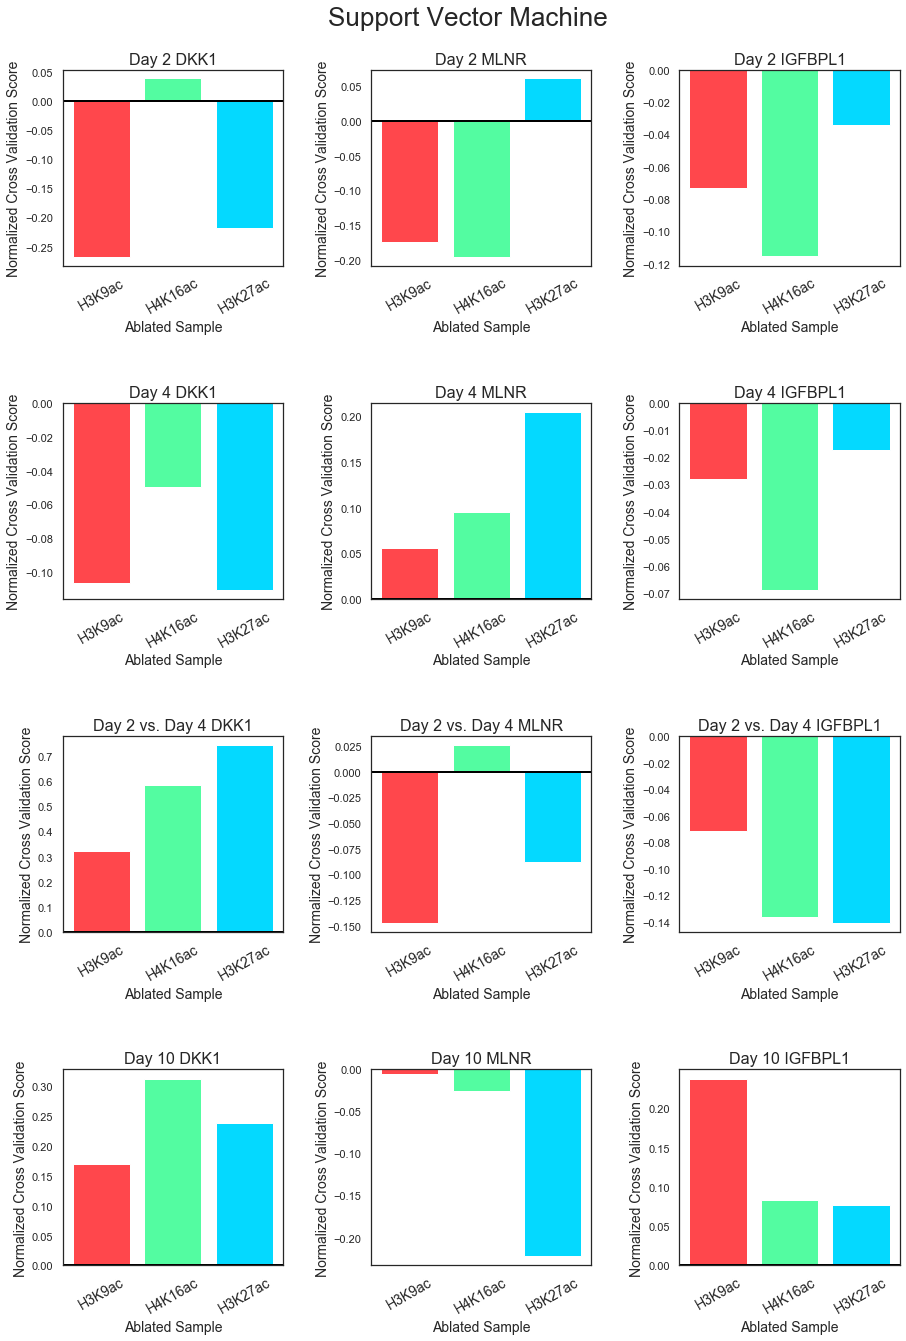

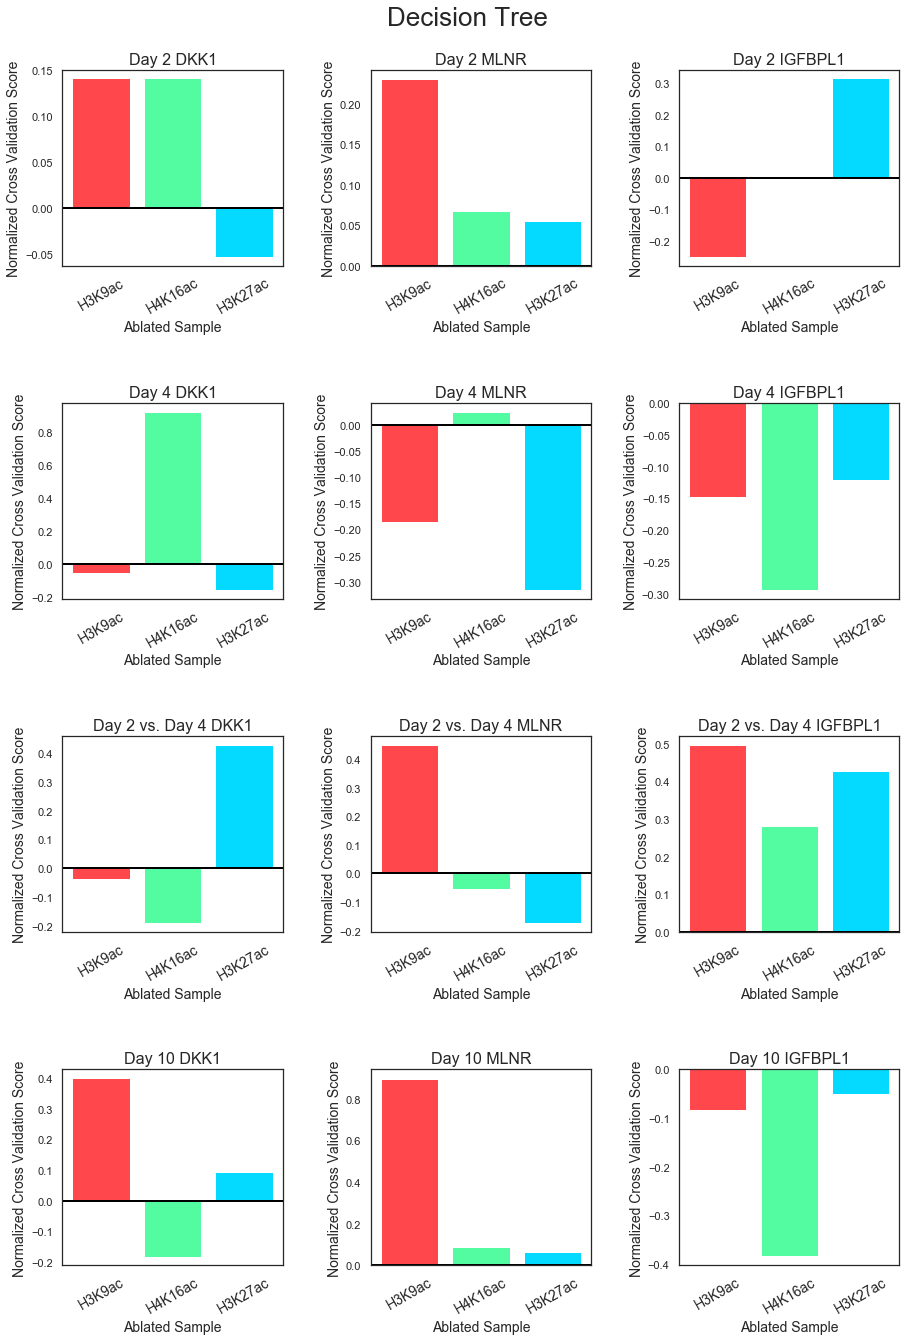

In [36]:
analyse(files,ignore_me=True)

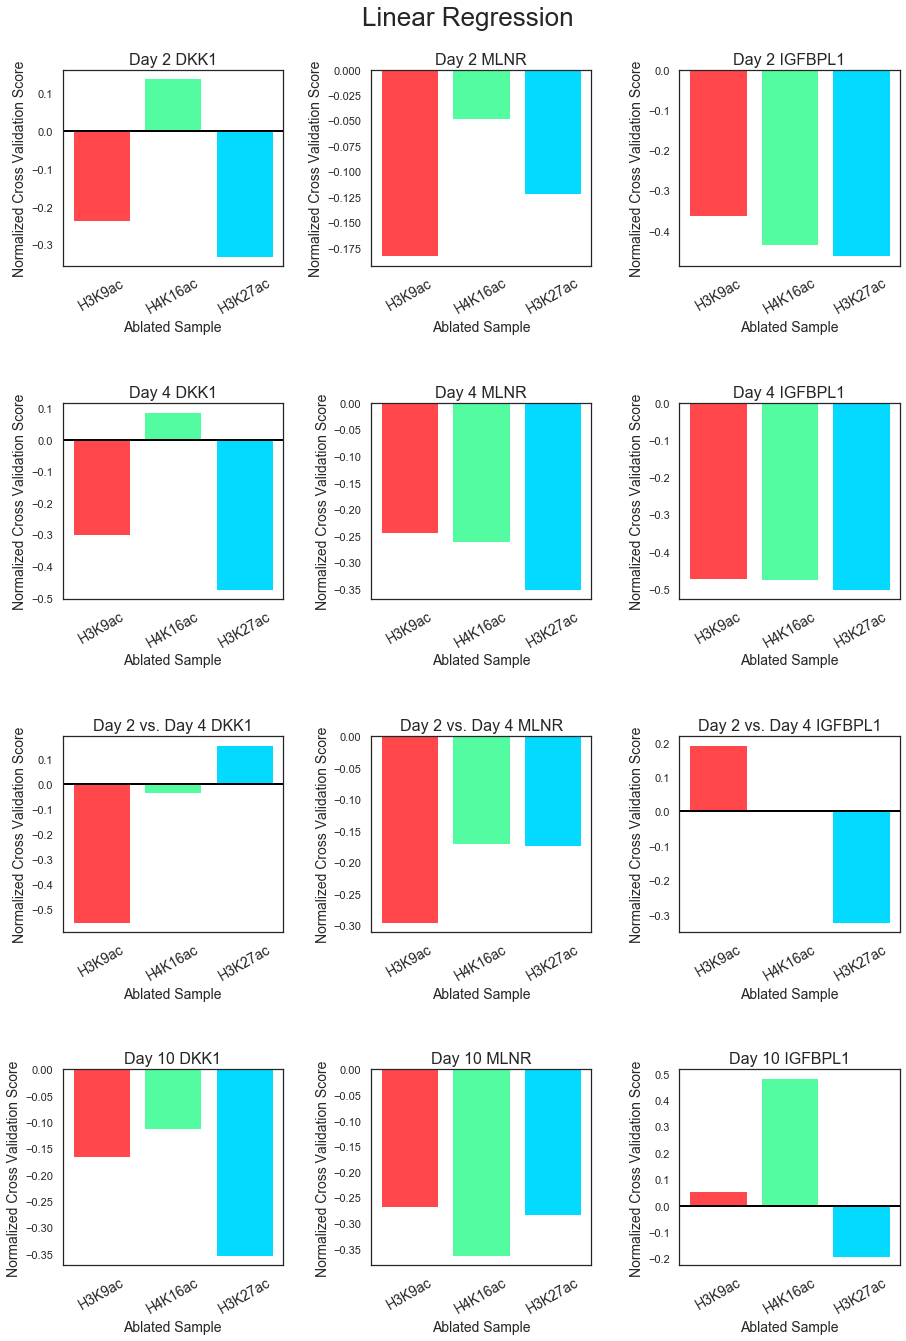

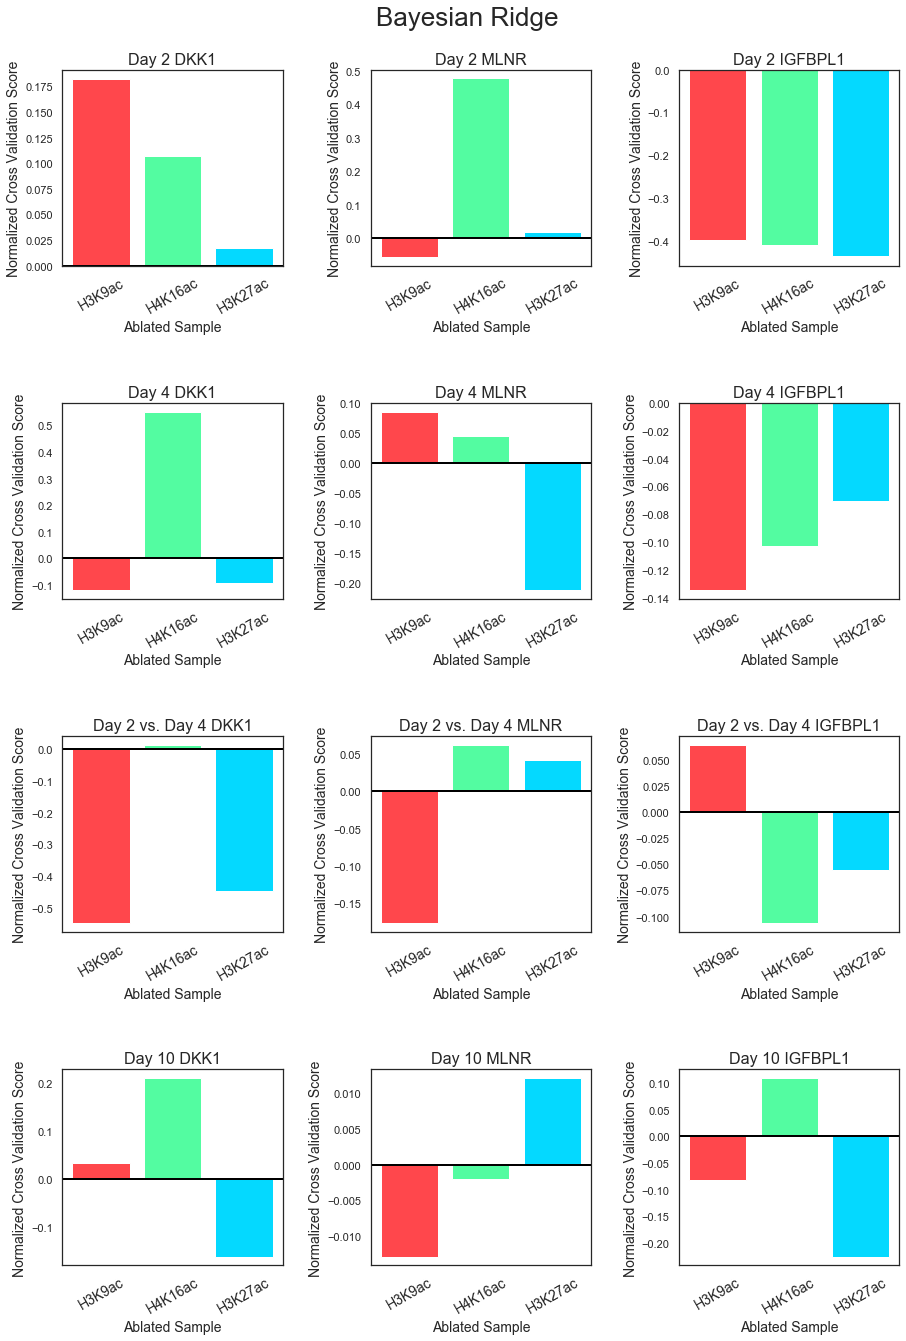

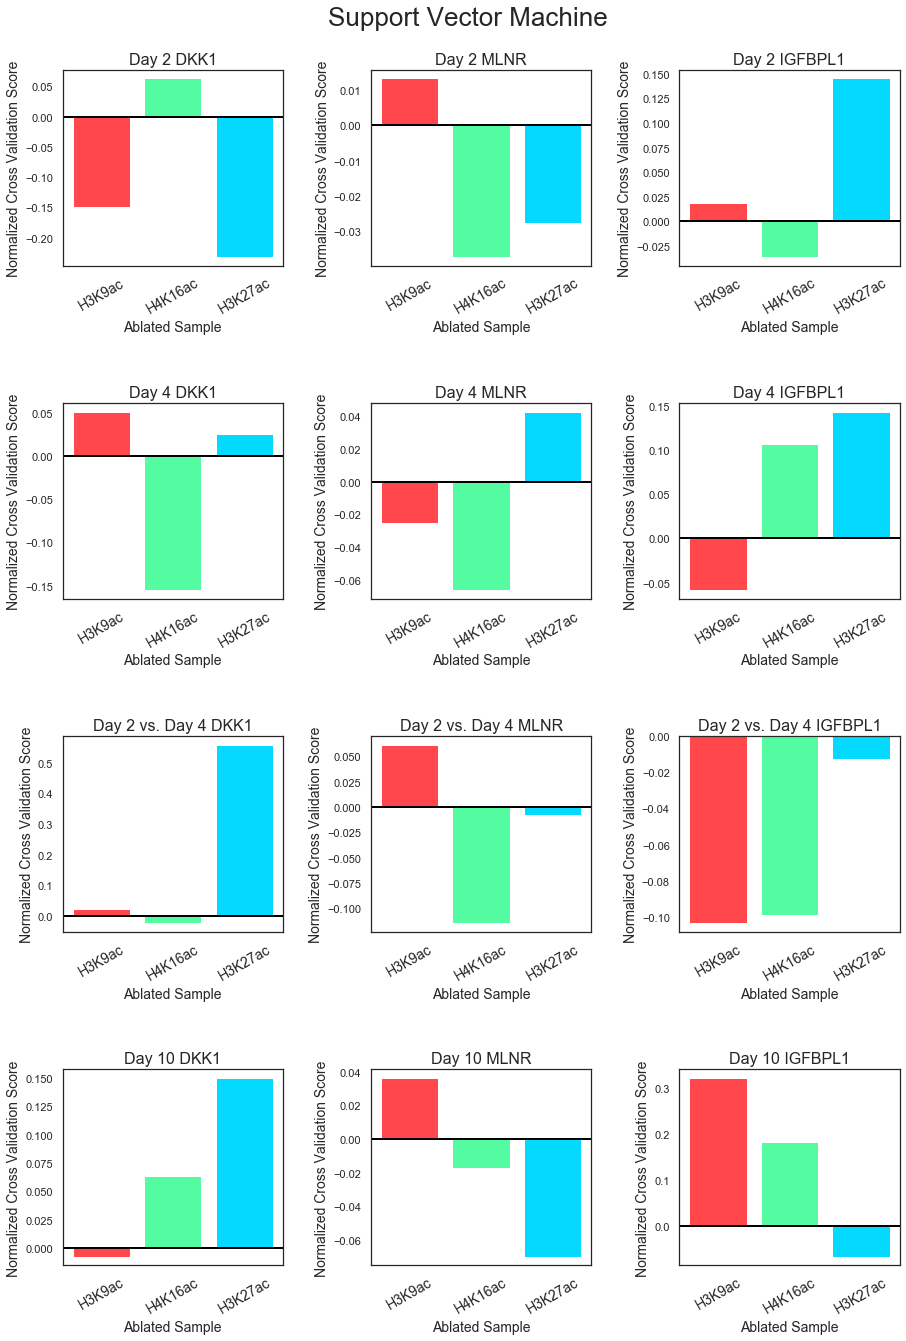

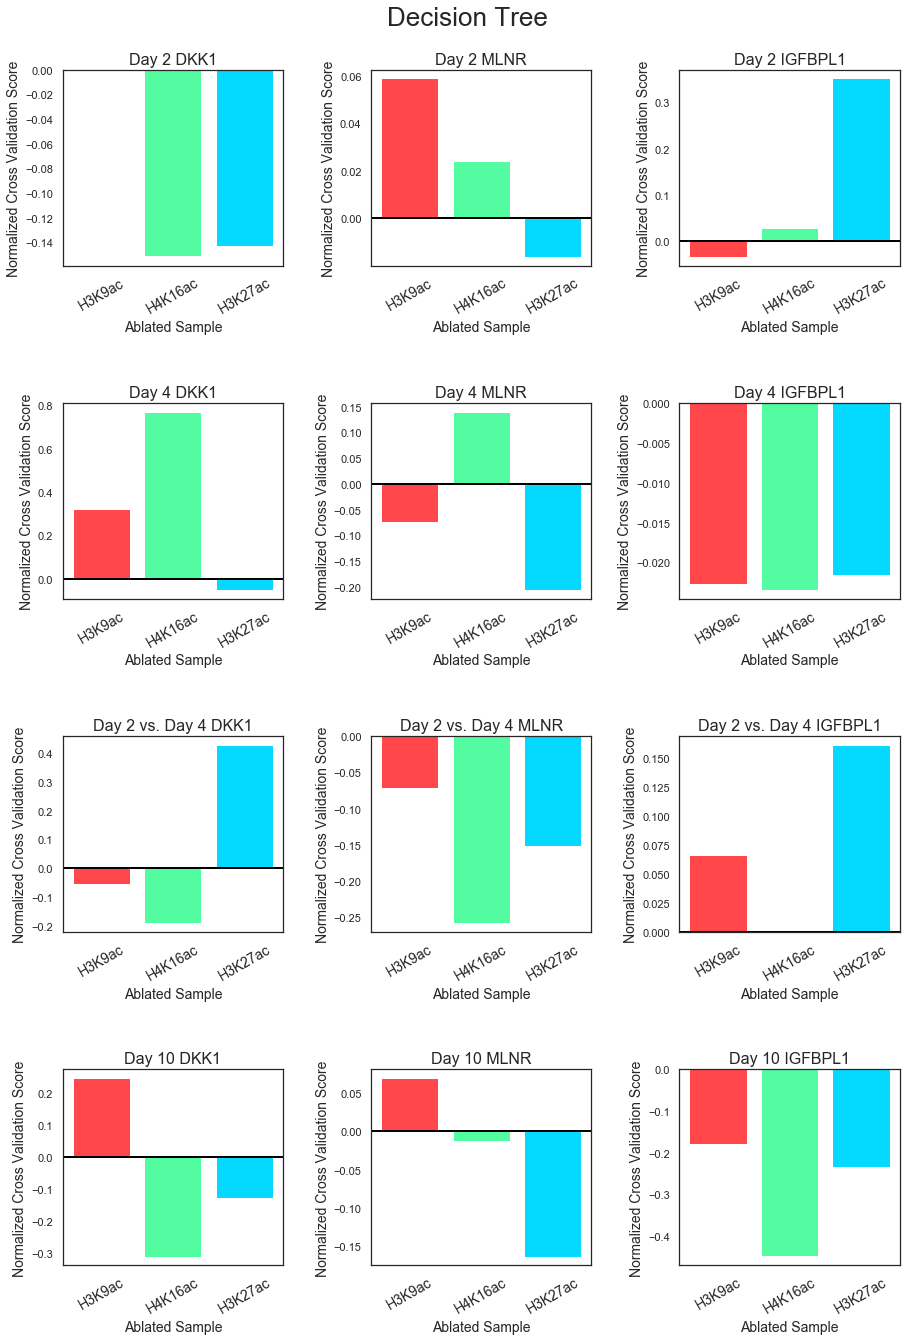

In [34]:
analyse(files,log_transform=True,ignore_me=True)

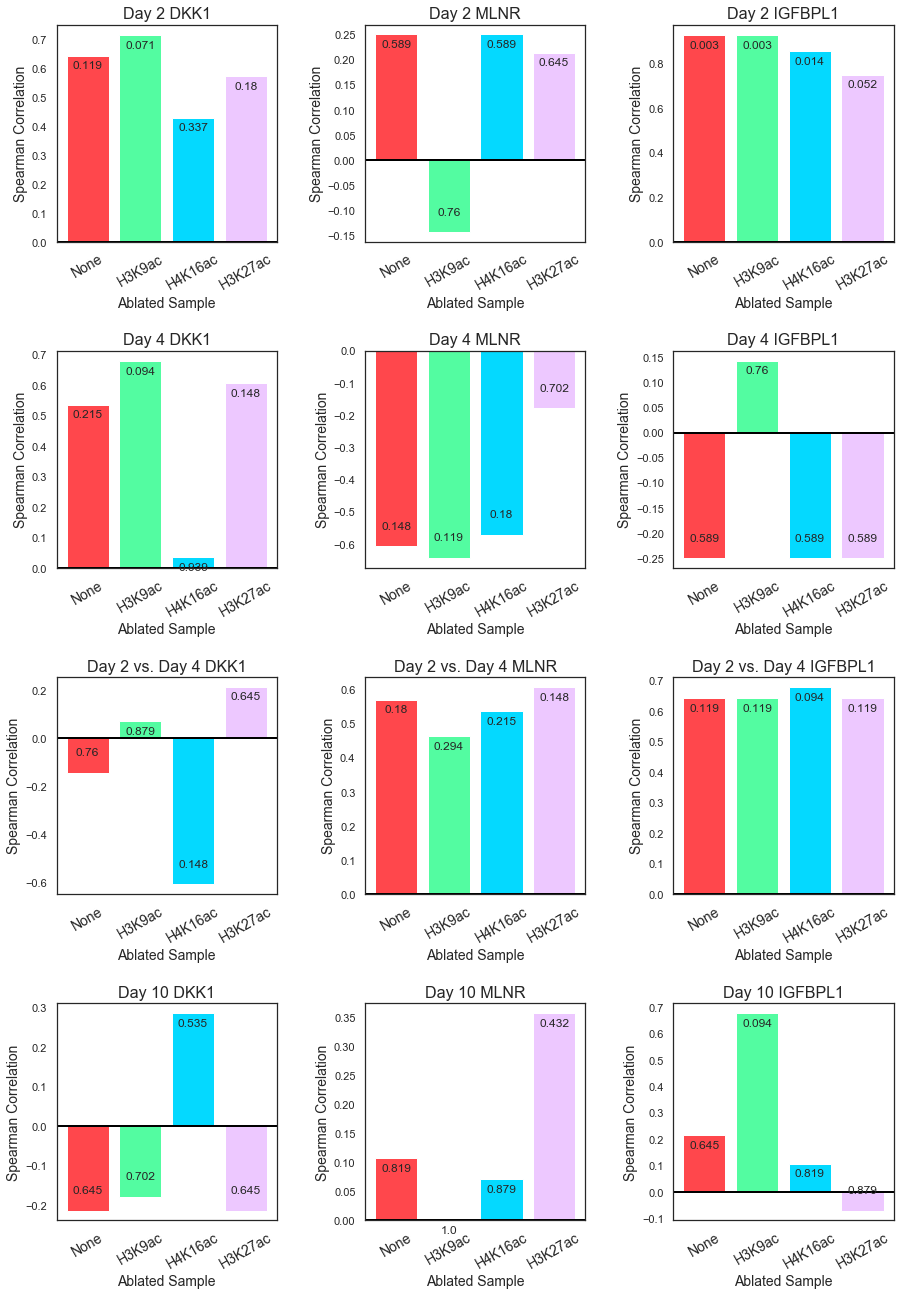

In [37]:
spearman_ablation(files)
#values printed represent P-values, if spearman corr drops after ablation, it means that mark was important
# https://wisostat.uni-koeln.de/fileadmin/sites/statistik/pdf_publikationen/SchmidSchmidtSpearmansRho.pdf
# If you can figure out this math it would be better than the current averaging method I am using

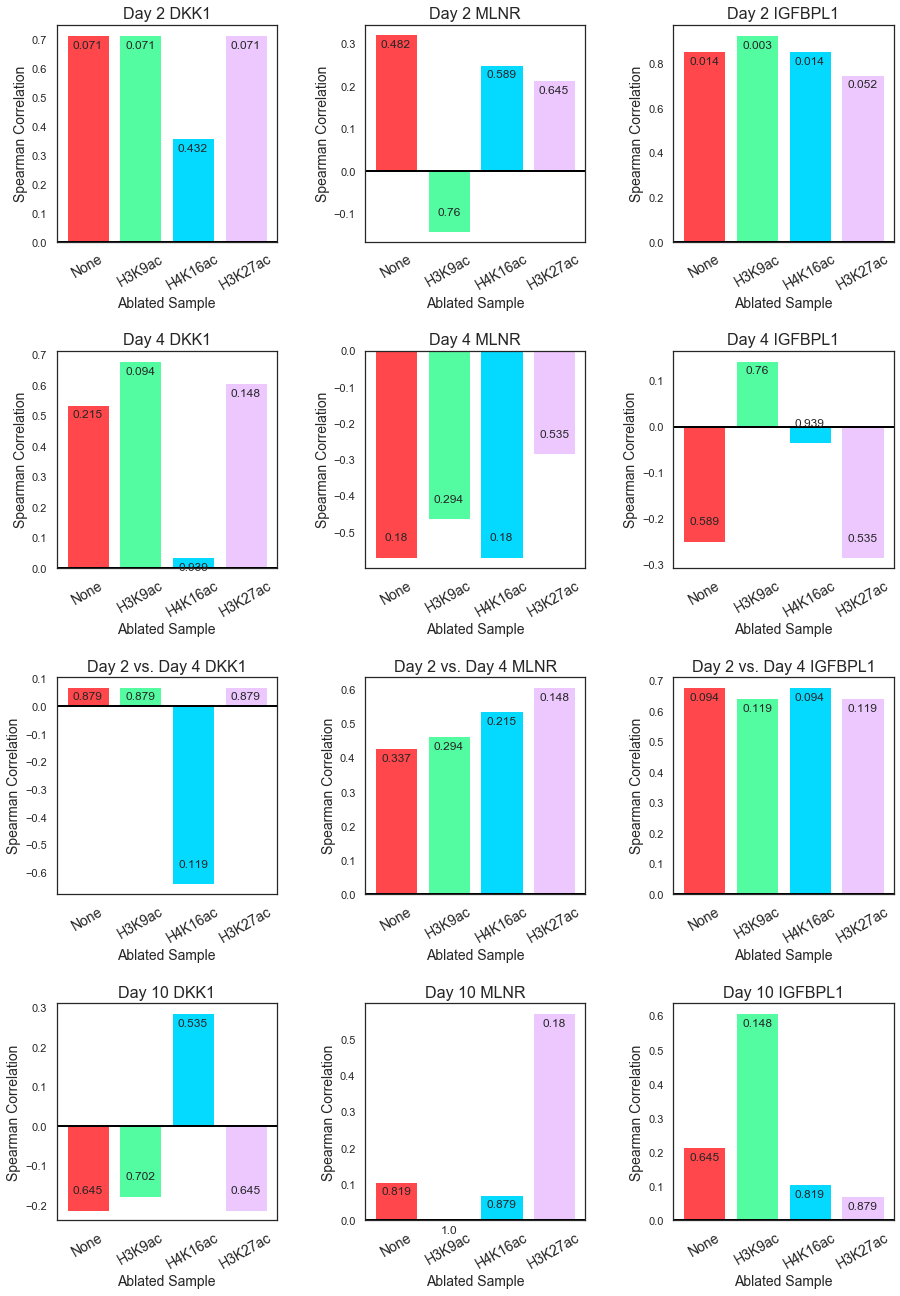

In [38]:
spearman_ablation(files,log_transform=True)